# Autoencoders

## Шаг 1
В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Вам нужно скачать оттуда lfw-deepfunneled.tgz и lfw_attributes.txt. Архив .tgz нужно распаковать =) После этого у вас появится папка с папками с лицами людей.

P.S. Не забудьте разбить выборку на train и test (нет, не в отдельные папки, а при загрузке в память компьютера в ноутбуке =))

P.P.S. для улучшения обучения автоэекодера полезно перевести величины пикселей картинки в отрезок [0, 1] (изначально они в интервале [0, 255]), а также привести их к типу float. Также удобно для начала сделать resize картинок в размер ~ (45, 45), чтобы обучить автоэнкодер было проще. Потом вы можете увеличить картинки как хотите, и усложнять вместе с ними автоэнкодер.

In [59]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
zip_path = '/content/gdrive/My Drive/Colab Notebooks/final/lfw.tgz'
data_path = '/content/gdrive/My Drive/Colab Notebooks/final/'

In [0]:
import urllib.request
import tarfile

print('Downloading dataset ...')

url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'  
urllib.request.urlretrieve(url, zip_path)  

print('Dataset downloaded!')

tar = tarfile.open(zip_path, "r:gz")
tar.extractall(data_path)
tar.close()
print('Dataset uzipped!')

Dataset downloaded!
Dataset uzipped!


## Шаг 2

Пока скачивается датасет, можно набросать план действий:

Разботать и реализовать автоэнкодер. Обычный (как на картинке)
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Вектор в середине (выход ancoder'а) называется латентным вектором/представлением картинки.

Для начала стоит почитать статьи/посты про автоэнкодеры. Автоэнкодер будет представлять собой класс-наследник nn.Module (как и обычно). Параметры типа кол-ва слоев, кол-ва нейронов в каждом слое и прочие советую вынести в отдельные переменные, чтобы потом было проще менять (вряд ли вы сразу угадаете, сколько слоев/нейронов вам нужно). Ну и, собственно, натренировать автоэекодер =) 

В процессе тренировки автоэекодера полезно следить не только за лоссом, но и за тем, как автоэнкодер восстанавливает каринки. Не поленитесь и напишите код, который каждую эпоху (например) будет прогонять через автоэнкодер несколько картинок из val выборки и выводить на экран полученные реконструкции.

P.S. какой будет структура автоэнкодера -- свертки, только fully-connected -- решать Вам. Можно заставить работать и так, и так. Эксперементируйте =) 

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import pickle
import random
from torch import nn
from PIL import Image
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision.utils import save_image

In [0]:
class Faces(Dataset):
    def __init__(self, root_dir=data_path, transform=None, dumped_dataset_path=None):
        self.root_dir = root_dir
        
        if transform is not None:
          self.transform = transform
        else:
          self.transform = transforms.Compose([
              transforms.Resize((125, 125)),
              transforms.RandomChoice([
              transforms.RandomRotation(10),
              transforms.RandomAffine(10),
              transforms.RandomHorizontalFlip(),
              transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
              ]),
              transforms.ToTensor(), ])
          
        if dumped_dataset_path is None:
          self.dataset = [] 

          i = 0
          for filename in os.listdir(self.root_dir  + 'lfw'):
            for image in os.listdir(self.root_dir + 'lfw/' + filename + '/'):
              i += 1
              if i % 100 == 0: 
                print(i, self.root_dir + 'lfw/' + filename + '/' + image)

              img = Image.open(self.root_dir + 'lfw/' + filename + '/' + image)
              if self.transform:
                img = self.transform(img)
              self.dataset.append(img)
        else:
          with open(dumped_dataset_path, "rb") as data:
            self.dataset = pickle.load(data)
            
        self.X_train = self.dataset[:int(len(self.dataset)*0.9)]
        self.X_test = self.dataset[int(len(self.dataset)*0.9):]

    def __len__(self):
        return len(self.X_train)
    def __getitem__(self, idx):
        return  self.X_train[idx]

In [0]:
# Можно загрузить заранее сохраненный датасет
face_dataset = Faces(dumped_dataset_path=data_path + "faces.bin")
# Если после первого раза не сохранили датасет, нужно из папки загрузить все картинки в память, но это долго
# face_dataset = Faces()

In [0]:
# import pickle

# with open(data_path + "faces.bin", "wb") as output:
#     pickle.dump(face_dataset.dataset, output)
    
# with open(data_path + "faces.bin", "rb") as data:
#     face_dataset.dataset = pickle.load(data)

11909
[3468, 5298, 8604, 2169]
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])


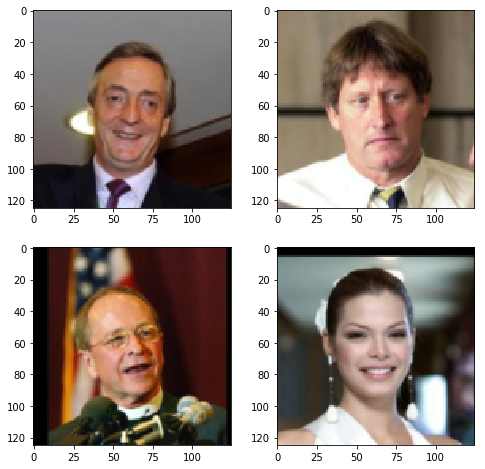

In [64]:
# выведем несколько картинок 

from random import randint

print(len(face_dataset))
x = [randint(0, len(face_dataset) - 1) for p in range(0, 4)]
print(x)

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows + 1):
  fig.add_subplot(rows, columns, i)
  print(face_dataset[x[i-1]].permute(1, 2, 0).shape)
  plt.imshow(face_dataset[x[i-1]].permute(1, 2, 0))
plt.show()

In [0]:
# гиперпараметры (не все)
learning_rate = 1e-5
batch_size=128
num_epochs = 1000

In [0]:
# этот автоэнкодер не имеет сверточных слоев

from copy import deepcopy

img_height = 125
img_length = 125

class Autoencoder(nn.Module):
    def __init__(self):
      super(Autoencoder, self).__init__()
      self.encoder = nn.Sequential(
        nn.Linear(img_length * img_height *3, 4096),
        nn.ReLU(True),
        nn.Linear(4096, 2048),
        nn.ReLU(True), 
        nn.Linear(2048, 1024), 
        nn.ReLU(True), 
        nn.Linear(1024, 1024), 
        nn.Tanh())
      self.decoder = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 2048),
        nn.ReLU(True),
        nn.Linear(2048, 4096),
        nn.ReLU(True), 
        nn.Linear(4096, img_length * img_height*3), 
        nn.Tanh())
        
    def forward(self, x):       
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code
      
    def generate_random_face(self):
      latent_code =  np.tanh(np.random.randn(1024))
      latent_code = Variable(torch.from_numpy(latent_code).float()).cuda()
      generated = self.decoder(latent_code)
      return generated

In [0]:
model = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [0]:
dataloader = DataLoader(face_dataset, batch_size=batch_size, shuffle=True)

In [0]:
def to_img(x):
  x = x.clamp(0, 1)
  x = x.view(3, img_height, img_length)
  return x

In [70]:
model.load_state_dict(torch.load(data_path + './sim_autoencoder.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
for epoch in range(num_epochs):
    for img in dataloader:
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # forward
        reconstruction, latent_code = model(img)

        loss = criterion(reconstruction, img)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    
    if epoch % 100 == 0:
      pic = to_img(reconstruction[0].cpu().data)
      save_image(pic, data_path + '/generated/' + 'image_{}.png'.format(epoch))

torch.save(model.state_dict(), data_path + './sim_autoencoder.pth')

epoch [1/1000], loss:0.0491
epoch [2/1000], loss:0.0546
epoch [3/1000], loss:0.0487
epoch [4/1000], loss:0.0568
epoch [5/1000], loss:0.0474
epoch [6/1000], loss:0.0431
epoch [7/1000], loss:0.0401
epoch [8/1000], loss:0.0391
epoch [9/1000], loss:0.0340
epoch [10/1000], loss:0.0443
epoch [11/1000], loss:0.0451
epoch [12/1000], loss:0.0342
epoch [13/1000], loss:0.0371
epoch [14/1000], loss:0.0518
epoch [15/1000], loss:0.0404
epoch [16/1000], loss:0.0384
epoch [17/1000], loss:0.0334
epoch [18/1000], loss:0.0321
epoch [19/1000], loss:0.0272
epoch [20/1000], loss:0.0408
epoch [21/1000], loss:0.0328
epoch [22/1000], loss:0.0391
epoch [23/1000], loss:0.0198
epoch [24/1000], loss:0.0328
epoch [25/1000], loss:0.0360
epoch [26/1000], loss:0.0373
epoch [27/1000], loss:0.0274
epoch [28/1000], loss:0.0311
epoch [29/1000], loss:0.0201
epoch [30/1000], loss:0.0341
epoch [31/1000], loss:0.0294
epoch [32/1000], loss:0.0242
epoch [33/1000], loss:0.0266
epoch [34/1000], loss:0.0356
epoch [35/1000], loss:0

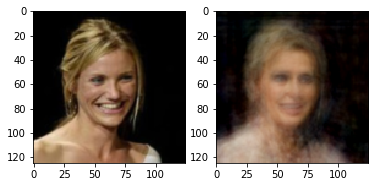

In [71]:
# from train set
for img in dataloader:
  img = img.view(img.size(0), -1)
  img = Variable(img).cuda()
  reconstructed, latent_code = model(img)
  break

_, axarr = plt.subplots(1,2)
axarr[0].imshow((img.cpu()[0]).view(3, img_height, img_length).permute(1, 2, 0))
axarr[1].imshow(to_img(reconstructed[0].cpu().data).permute(1, 2, 0))

1324
952
torch.Size([1, 46875])


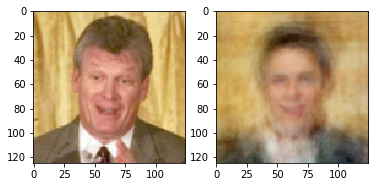

In [85]:
# from test set
print(len(face_dataset.X_test))
rand_idx = randint(0, len(face_dataset.X_test) - 1)
print(rand_idx)

img = face_dataset.X_test[rand_idx].view(1,-1)
img = Variable(img).cuda()
print(img.shape)
reconstructed, latent_code = model(img)

_, axarr = plt.subplots(1,2)
axarr[0].imshow((img.cpu()[0]).view(3, img_height, img_length).permute(1, 2, 0))
axarr[1].imshow(to_img(reconstructed[0].cpu().data).permute(1, 2, 0))

torch.Size([46875])


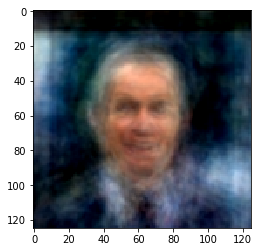

In [99]:
# генерим случайное лицо 
generated = model.generate_random_face()
generated *= 10 # increase brightness
print(generated.shape)
plt.imshow(to_img(generated.cpu().data).permute(1, 2, 0))

Лепим улыбку

In [0]:
transform = transforms.Compose([
              transforms.Resize((125, 125)),
              transforms.ToTensor(), ])

In [0]:
happy_dataset = [] 

for image in os.listdir(data_path  + 'happy'):
  img = Image.open(data_path + 'happy' + '/' + image)
  img = transform(img)
  happy_dataset.append(img)

In [0]:
unhappy_dataset = [] 

for image in os.listdir(data_path  + 'unhappy'):
  img = Image.open(data_path + 'unhappy' + '/' + image)
  img = transform(img)
  unhappy_dataset.append(img)

16 16


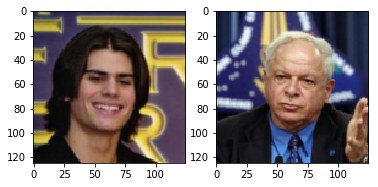

In [152]:
random_index = random.randint(0, len(happy_dataset)-1)

print(len(happy_dataset), len(unhappy_dataset))
_, axarr = plt.subplots(1,2)
axarr[0].imshow(happy_dataset[random_index].permute(1, 2, 0))
axarr[1].imshow(unhappy_dataset[random_index].permute(1, 2, 0))

In [153]:
mean_latent_code_happy = 0
mean_latent_code_unhappy = 0

for img_happy, img_unhappy in zip(happy_dataset,unhappy_dataset):
  img_happy = img_happy.view(1, -1)
  img_unhappy = img_unhappy.view(1, -1)
  
  img_happy = Variable(img_happy).cuda()
  img_unhappy = Variable(img_unhappy).cuda()
  
  reconstruction_happy, latent_code_happy = model(img_happy)
  mean_latent_code_happy += latent_code_happy/16
  
  reconstruction_unhappy, latent_code_unhappy = model(img_unhappy)
  mean_latent_code_unhappy += latent_code_unhappy/16
  
print(mean_latent_code_happy, mean_latent_code_unhappy)

tensor([[ 0.2079, -0.6481,  0.4261,  ...,  0.0609, -0.1550, -0.0868]],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([[ 0.0169, -0.7015,  0.5177,  ...,  0.0120, -0.2651,  0.0186]],
       device='cuda:0', grad_fn=<AddBackward0>)


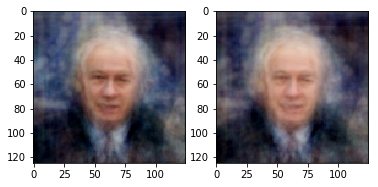

In [154]:
diff_vector = mean_latent_code_happy - mean_latent_code_unhappy

img_unhappy = unhappy_dataset[random_index]
img_unhappy = img_unhappy.view(1, -1)
img_unhappy = Variable(img_unhappy).cuda()

reconstruction_unhappy, latent_code_unhappy = model(img_unhappy)\

add_smile = latent_code_unhappy + diff_vector
simely = model.decoder(add_smile)

_, axarr = plt.subplots(1,2)
axarr[0].imshow(to_img(reconstruction_unhappy.cpu().data).permute(1, 2, 0))
axarr[1].imshow(to_img(simely.cpu().data).permute(1, 2, 0))

## Шаг 3

Если вы смогли подобрать параметры сети и обучить ее, то пора начать играться =)

Играться можно так:

а) сгенерировать рандомные латентные векторы (без энкодера, например, с помощью np.random.randn), скормить их decoder'у и посмотреть, что получится. То есть, вы сможете создавать новые лица людей из векторов

б) Второе, что предлагается сделать -- научить лепить улыбки на лица грустных людей.

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# BONUS 1. 
### Variational Autoencoder

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

В этом бонусе предлагается научиться реализовывать Variational autoencoders. После этого с ним можно точно так же играться -- генерить новых людей (кстати, сравните с тем, как генерит обычный автоэнкодер -- кто круче и почему?) пририсовывать улыбки тем же самым способом, что и для обычного autoencoder. Вперед!